# Identifying factors that determine a video game's success
You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns

# Table of Contents

1. [General Information](#step1)
2. [Data Preprocessing](#step2)
3. [Analysis](#step3)
4. [Users profile for each region](#step4)
5. [Hypothesis Testing](#step5)
6. [Overall Conclusion](#step6)

## General Information <a name='step1'></a>

We will import the necessary libaries for our project

In [1]:
from scipy import stats as st #for probability and statistics calculations
import pandas as pd #for dataframe manipulation
import matplotlib.pyplot as plt #for graph plotting and display
import numpy as np #for advanced mathematical operations
import nltk #for string/text manipulation

We will now convert our dataset into a dataframe

In [2]:
games = pd.read_csv('/datasets/games.csv') #reads the csv file and converts it into a dataframe called games
games.head() #first 5 rows of our games dataframe

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info() #general information about our games table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


We have to make our column names uniform by converting them all to lowercase, then do something about the missing values in 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score', and 'Rating'

- **Conclusion**

We have opened the file and looked at its general information. We were able to spot issues that need fixing

## Data Preprocessing <a name='step2'></a>

- ***Column names to lowercase***

We do this to make it easier to refer to them in our code and for uniformity. We will use the 'str.lower()' method

In [4]:
games.columns = games.columns.str.lower()
#this changes the column names to lowercase and saves the changes

games.info() #general info about our games table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


All column names are now in lowercase 

### The 'platform' column

We just need to lowercase the values

In [5]:
games['platform'] = games['platform'].str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,nes,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,gb,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### The 'name' column

It has only two missing values (which were either not put in or got lost in the copying process) and there is no way to fill the actual name of the game. So we will leave them blank. However, we can convert the values to lowercase

In [6]:
games['name'] = games['name'].str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Let us take a look at the different unique values in the name column 

In [7]:
games['name'].unique() #lists all the unique values in the name column

array(['wii sports', 'super mario bros.', 'mario kart wii', ...,
       'woody woodpecker in crazy castle 5', 'lma manager 2007',
       'haitaka no psychedelica'], dtype=object)

We can notice the entry: 'mario kart wii'. The name contains the platform. We should proceed based on the assumption that there are other entries that also contain their platforms in their names. Later on, we will be analyzing how games do across platforms, so we need a game to have the same name across platforms. It also helps to know that Mario Kart exists on other platforms. We will write a function that checks whether the name of the game has the platform in it and if it does, it takes it out of the name. Since we have missing values, we will use try-except blocks. In the try block we will store the code that will attempt to run if all is well. If it can't be run (like in the case of a missing value), the code that we will store in the except block will be run

In [8]:
def no_p_name(row): #creates a function called no_p_name that takes a row as argument
    try: #attempt the following code
        name=row['name'] #stores the value of the name column on a row in a variable called name
        
        #conditional statement
        if row['platform'] in row['name']:
        #if the value of the platform column is found in the value of the name on the same row
            
            name = row['name'].strip(row['platform'])
            #the name variable takes off the platform from the name value
            
            return name
            #returns the value of the name variable
        return name
        #returns the value of the name variable if the above condition wasn't fulfilled
    
    except: #if the code in the try block can't be run
        name=row['name']#stores the value of the name column on a row in a variable called name
        return name #returns the value of the name variable
    
games['name'] = games.apply(no_p_name, axis=1)
#applies the no_p_name function to the games dataframe and saves the results to our name column

games.head() #first 5 rows of the games dataframe

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,sports,wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart,wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,sports resort,wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### The 'year_of_release' column

We can attempt to replace the missing values with the median. However, we will not use the global median. Every year value will be filled the median year value for its platform. We do this so that the value we are filling are as representative of the dataset as possible. To do so, we can group our data by 'platform' and calculate the median year of release on each platform. Then we can apply a function that checks our data for rows for missing year_of_release values. When it finds one, it will check its platform then return the median year_of_release value for the platform from our grouped data

In [9]:
year_mapper = games.groupby('platform')['year_of_release'].median().to_dict()
#groups the games table by platform and fetches the median year of release for games on the platform
#and converts it into a dictionary called year_mapper

def year_fill(row):#creates a function called year_fill which takes a row as its argument
    if np.isnan(row['year_of_release']):#if the year_of_release value is missing
        return year_mapper.get(row['platform'])
        #returns the median year_of_release of its platform from the year_mapper dictionary
    return row['year_of_release']
    #returns the year_of_release if the value is already existing

games['year_of_release'] = games.apply(year_fill, axis=1)
#applies the year_fill function to the games table and saves the results to the year_of_release column
games.info()#general info about games dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


We need to first of all change the data type to integer

In [10]:
games['year_of_release'] = games['year_of_release'].astype('int')
#converts the values of the 'year_of_release' to integers

games.info() #general info about the games table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


### The 'genre' column

It has only two missing values (which were either not put in or got lost in the copying process) and there is no way to fill the actual genre of the game (not without playing it, at least). So we will leave them blank. We can, however, change the values to lowercase

In [11]:
games['genre'] = games['genre'].str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [12]:
games['genre'] = games['genre'].fillna('undefined')
#fills missing values in the genre column with 'undefined'
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### The 'critic_score' column

Being a quantitative column, we can attempt to replace the missing values with the median. However, we will not use the global median. Every missing critic_score value will be filled the median critic_score value for its genre. We do this so that the value we are filling are as representative of the dataset as possible. To do so, we can group our data by 'genre' and calculate the median critic_score of each genre. Then we can apply a function that checks our data for rows for missing critic_score values. When it finds one, it will check its genre then return the median critic score value for the genre from our grouped data

In [13]:
c_score_mapper = games.groupby('genre')['critic_score'].median().to_dict()
#this groups 'games' by genre, calculates the median critic score
#and converts the resulting dataframe into a dictionary called c_score_mapper

def c_score_fill(row): #creates a function called c_score_fill that takes a variable 'row' as argument
    if np.isnan(row['critic_score']): #if the critic_score value is missing
        return c_score_mapper.get(row['genre'])
        #returns the median critic_score value for genre from c_score_mapper
        
    return row['critic_score'] #returns the existing critic score value if it wasn't missing
games['critic_score'] = games.apply(c_score_fill, axis=1)
#applies the c_score_fill function to our games table and saves the results to the critic_score column

games.info() #general info about our games dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16713 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


We are down from over 8000 missing values to just 2. We will leave those blank

### The 'user_score' column

For starters, this column is of object type even though we see numbers in there. This means that it can take text string values also. So, before converting, let us check its values first. Let us apply the 'value_counts()' method to the column

In [14]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
1.1       2
0.7       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Our problem is at the top of the list: "tbd". It is used for video games that don't yet have a user score and appears 2424 times so we need to figure out what to do with it before converting the whole column to float type. Down the line, we will have to study the effect the reviews and sales. "tbd" is not a review; this just means the game is yet to be reviewed. So we will treat these games as having no review, so we will actually replace "tbd" with a NaN value

In [15]:
games['user_score'] = games['user_score'].replace({'tbd' : np.nan})
#replaces every 'tbd' value in the user_score column to NaN i.e a missing value
games['user_score'] = games['user_score'].astype('float')
#converts the data in the user_score column to float type
games.info()#general info about games dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16713 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


We will now replace all the NaN values with the mean. We can do so with the mean beacause we have float values within a defined range.

In [16]:
games['user_score'] = games['user_score'].fillna(games['user_score'].mean())
#replaces the missing values in the user_score with the mean value of the user_score column
games.info()#general info about the games dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16713 non-null float64
user_score         16715 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


### The 'rating' column

Let us take a look at the values in the rating column 

In [17]:
games['rating'].unique()#displays unique values in the rating column

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

This being a categorical column, we can't replace missing values with the mean or median. What we can do is the mode. So we will group the games dataframe by the genre, and for each genre, get the most popular rating and convert the resulting dataframe into a dictionary. Then, we can write a function that checks for rows with missing values in the rating column, checks their genre and returns the most popular rating for that genre. Then we can apply that function to the games table and save the results to the rating column

In [18]:
rating_mapper = games.groupby('genre')['rating'].agg(pd.Series.mode).to_dict()
#groups the games dataframe by the genre and fetches the most popular rating for each genre and converts the
#resulting dataframe into a dictionary called rating_mapper

def rating_fill(row):#creates a function called rating_fill that takes the row as argument
    if pd.isna(row['rating']):#if the rating value is missing
        return rating_mapper.get(row['genre'])
        #returns the most popular rating for its genre from the rating_mapper dictionary
    return row['rating']#returns the rating if the value already exists

games['rating'] = games.apply(rating_fill, axis=1)
#applies the rating_fill function to the games table and stores the results in the rating column
games.info()#general info about the games table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16713 non-null float64
user_score         16715 non-null float64
rating             16715 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


### Calculating total sales

For this, we will just add up the na_sales, eu_sales, and jp_sales columns and save the results to a new column called 'total_sales'

In [19]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16713 non-null float64
user_score         16715 non-null float64
rating             16715 non-null object
total_sales        16715 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


- **Conclusion**

We made all column names lowercase, we filled missing values in the platform, year_of_release, genre, critic_score, user_score, and rating columns. We also added a new total_sales column which adds the values from the na_sales, eu_sales, jp_sales, and other_sales columns

## Analysis <a name='step3'></a>

### Game Releases throughout the years

We can get this information by grouping the games table by the year of release and counting the number of game names for each year. 

In [20]:
year_count=games.groupby('year_of_release')['name'].count()
#creates a table called year count which groups the games table by year_of_release and gets a count of the
#game names for each year
year_count

year_of_release
1980       9
1981      46
1982      53
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     290
1998     386
1999     341
2000     350
2001     482
2002     829
2003     800
2004     783
2005     973
2006    1006
2007    1197
2008    1457
2009    1476
2010    1302
2011    1161
2012     653
2013     552
2014     582
2015     606
2016     502
Name: name, dtype: int64

We can visualize this on a bar chart 

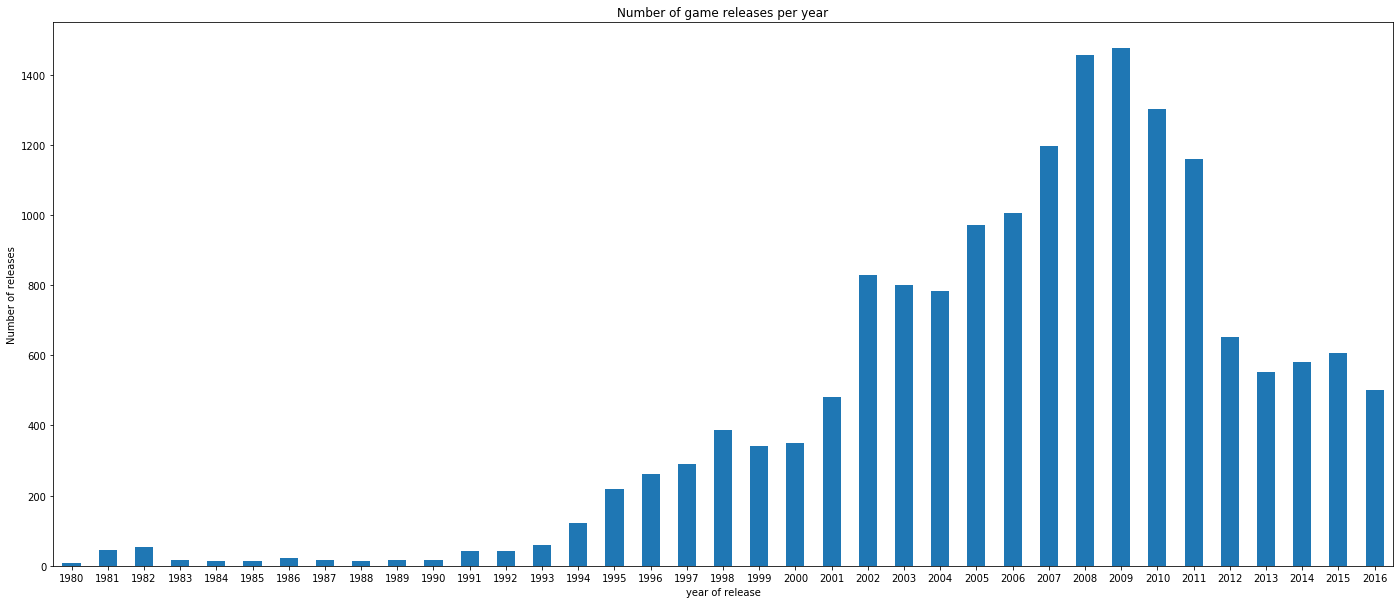

In [21]:
year_count.plot.bar(rot=0, figsize=(24, 10))
plt.title('Number of game releases per year')
plt.xlabel('year of release')
plt.ylabel('Number of releases')
plt.show()
#plots a bar chart for our year_count table showing the years and how many games each year had

Between 1980 and 1995, fewer than 200 video games were released per year. Video games started becoming more popular from 1995 onward with 2001 having about 500 releases. 2002 saw a sharp increase; over 800 games were released that year. 2007 to 2011 are the top when it comes to releases, with 2009 boasting 1476 releases (the peak). Not all periods are significant.

### Lifespan of a Platform

Let us first of all find the all-time total sales of each platform and rank them

In [22]:
platform_rank = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
#groups the games table by platform and finds the sum of the total sales for each platform in 
#descending order
top_platforms=platform_rank.head()
#takes the first 5 rows of the platform ranking table
top_platforms

platform
ps2     1255.77
x360     971.42
ps3      939.65
wii      907.51
ds       806.12
Name: total_sales, dtype: float64

PS2 leads with over 1 billion in sales, followed by X-box 360, PS3, Wii, and Nintendo DS. Now let us plot, for each of these platforms, bar charts showing the total sales in each year.

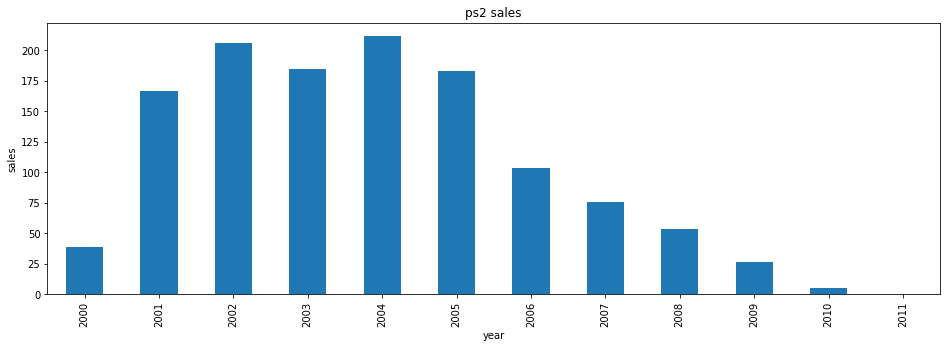

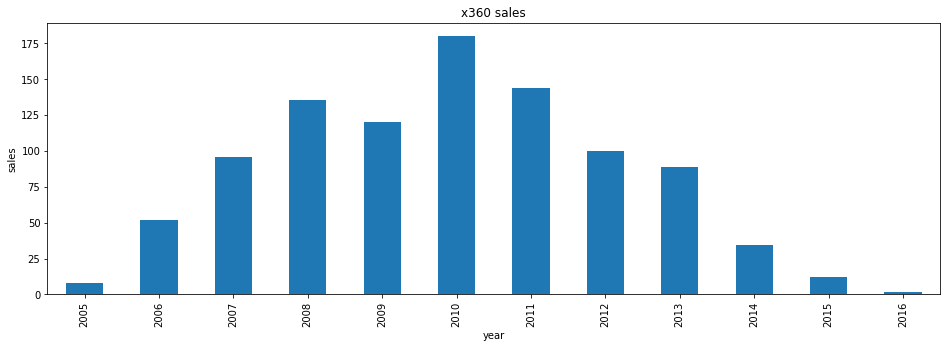

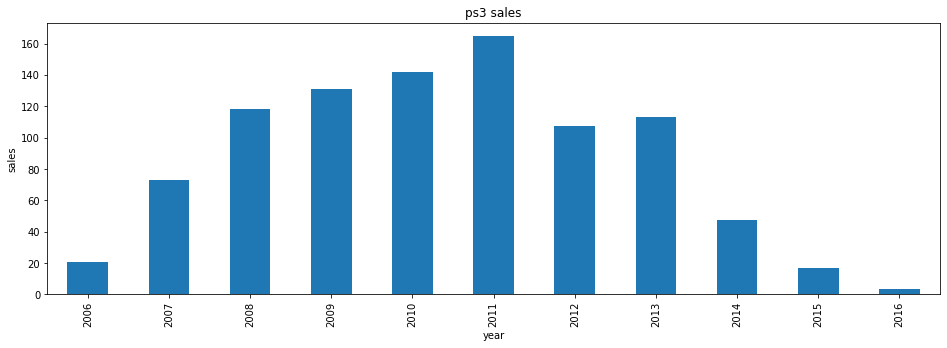

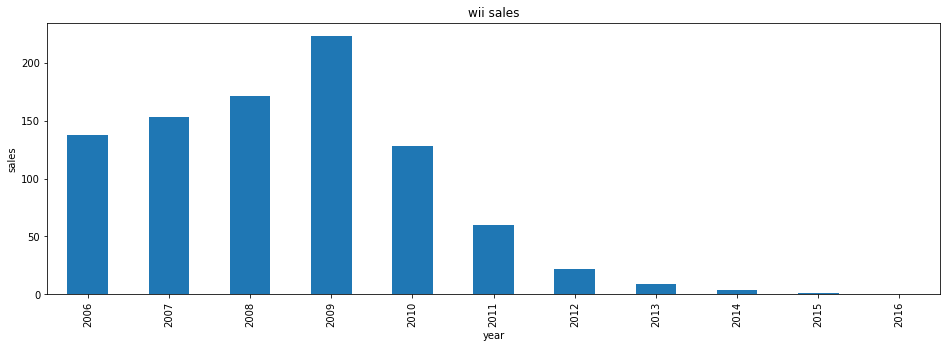

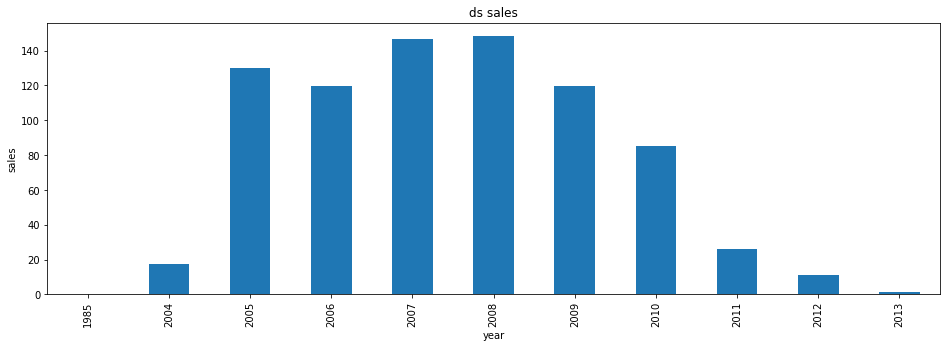

In [23]:
for platform in top_platforms.index: #loops through the top 5 platforms
    p_slice=games.query('platform == @platform')
    #creates a slice of rows from the games table where the value of the platform equals the top 5 platform
    p_slice.groupby('year_of_release')['total_sales'].sum().plot.bar(figsize=(16, 5))
    #groups the slice by year of release and gets the sum of the total sales for each year and plots a
    #bar chart
    plt.title('{} sales'.format(platform))#tilles the chart with the format ''<platform> sales'
    plt.xlabel('year')#labels the x-axis as 'year'
    plt.ylabel('sales')#labels the y-axis as 'sales'
    plt.show()#shows the chart
    print('')#prints an empty line

For PS2, it started in 2000 and saw an increase in sales and became hugely popular in 2004 after which we can observe a decline in sales and zero sales after 2010. Its successor the PS3 showed up in 2006, during the PS2's decline in sales. The wii showed up in 2006, peaked in 2009, after which it declined and registered sero sales after 2015. The wiiu, the wii's successor, showed up in 2012, during the wii's decline. The DS showed up in 2004, became hugely popular in 2007 and 2008, after which it declined and registered zero sales after 2013. So it takes 6 to 7 years for new consoles to appear and 9 to 10 years for a platform to completely disappear from the market. Our relevant data will start from the year 2007 so that we can have a timeline similar to a platform lifespan.

### Video game sales since 2007

In [24]:
relev_data = games.query('year_of_release >= 2007')
#creates a slice of rows where the year of release is 2007 and above 
relev_platform_rank = relev_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
#groups the relev_data by platform, gets the sum of total_sales for each platform and sorts them in
#descending order
relev_platform_rank

platform
ps3     918.69
x360    911.55
wii     770.36
ds      538.88
ps4     314.14
3ds     259.00
psp     187.83
pc      164.33
ps2     162.38
xone    159.32
wiiu     82.19
psv      54.07
gba       3.40
xb        0.73
gc        0.27
dc        0.06
Name: total_sales, dtype: float64

The PS3 leads in total sales since 2007, followed by x360, wii, ds, ps4 to make the top 5. To know those that are growing or shrinking, we will plot bar charts for each platform.

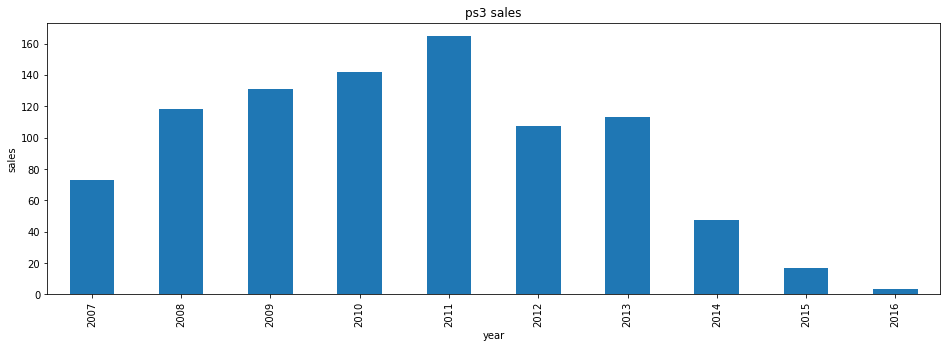

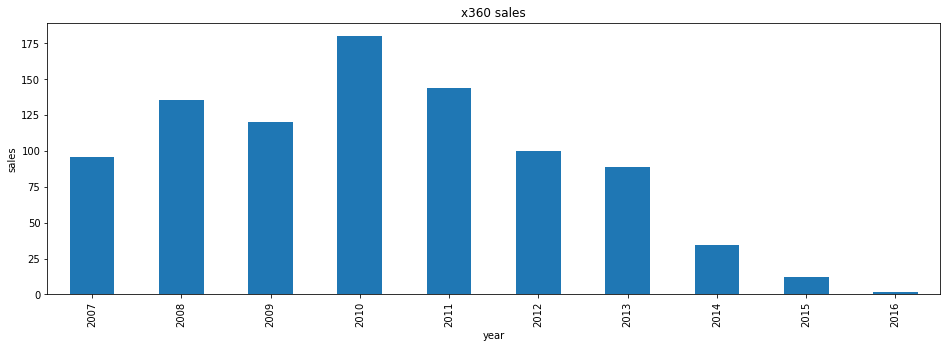

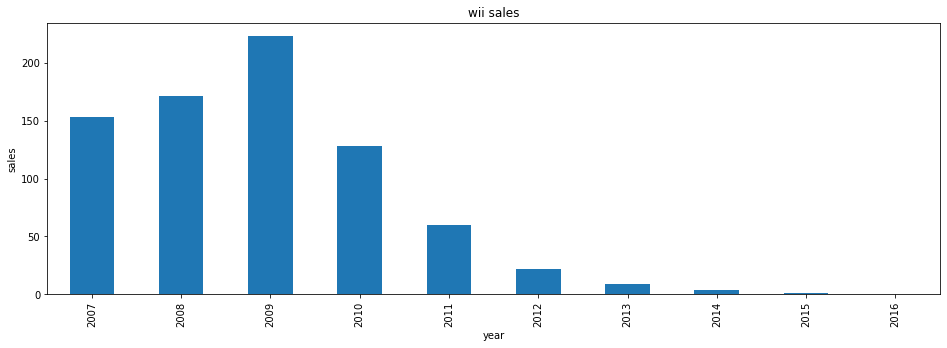

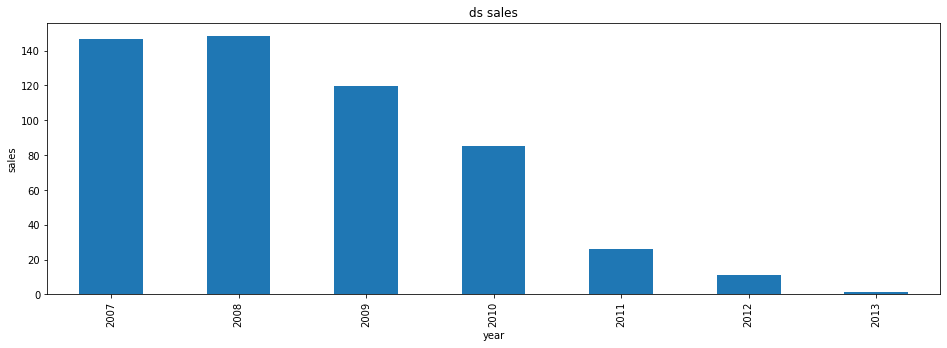

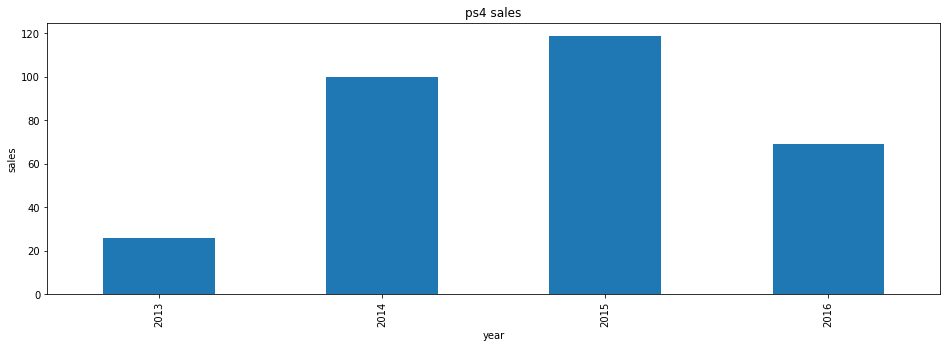

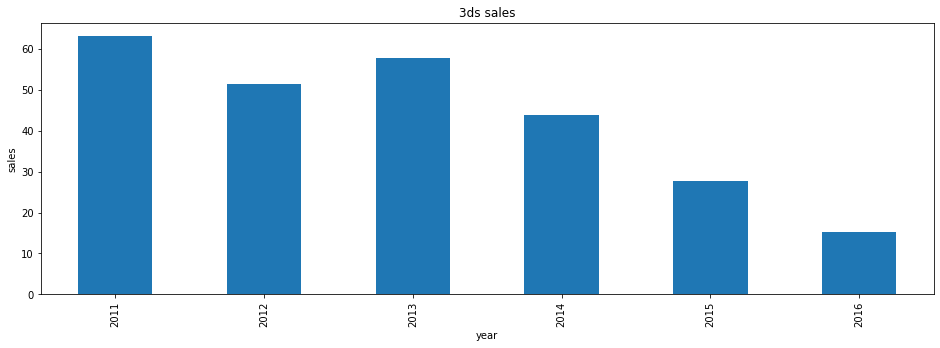

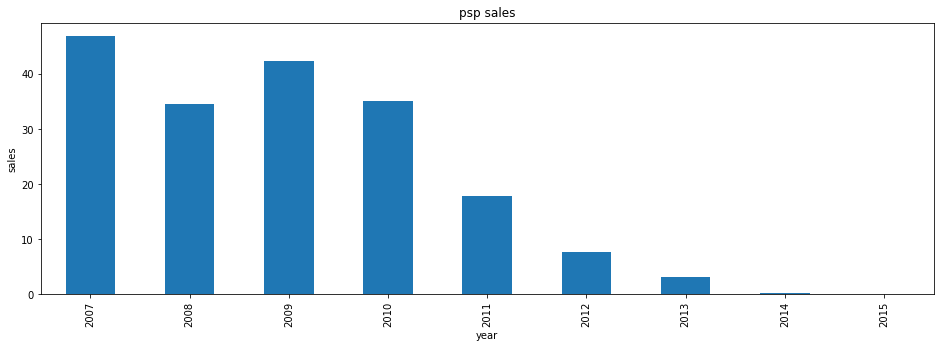

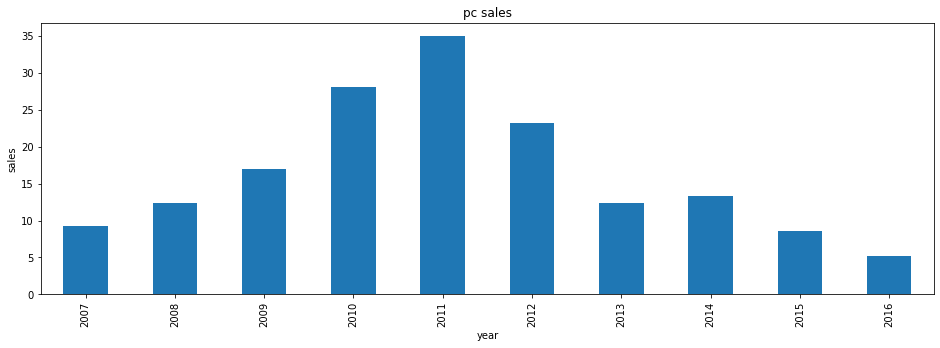

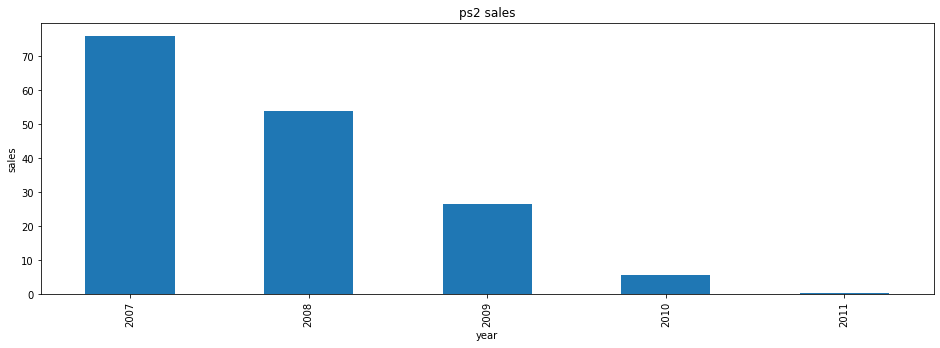

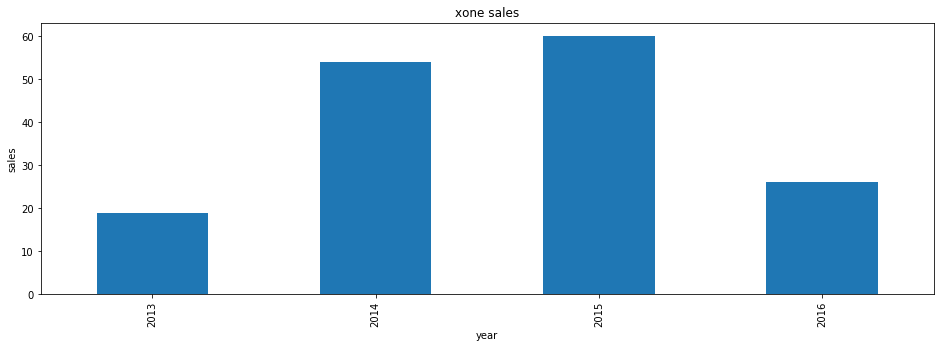

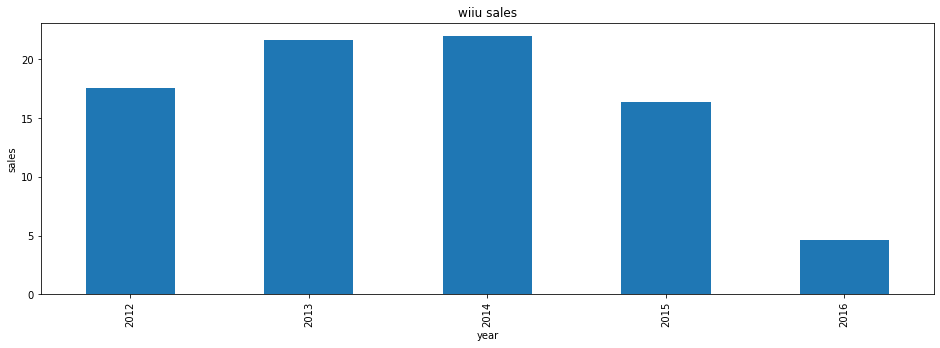

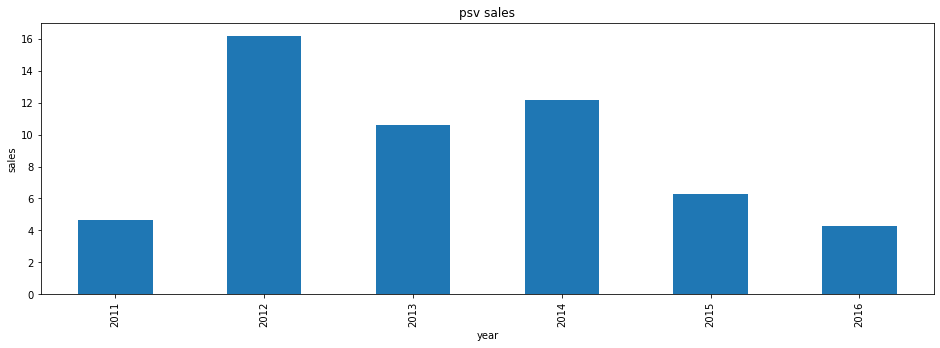

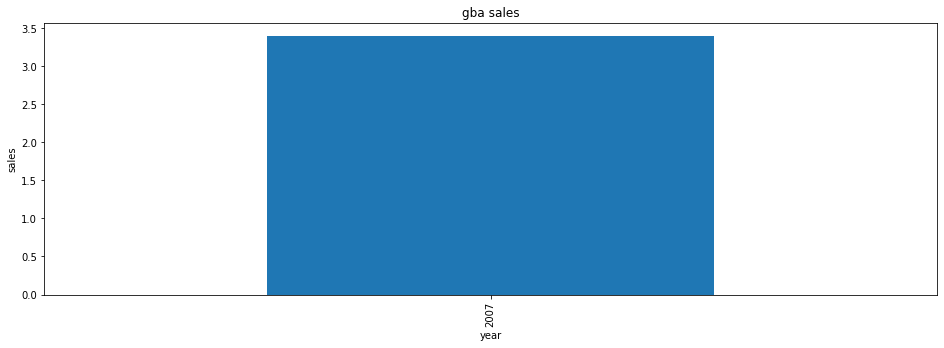

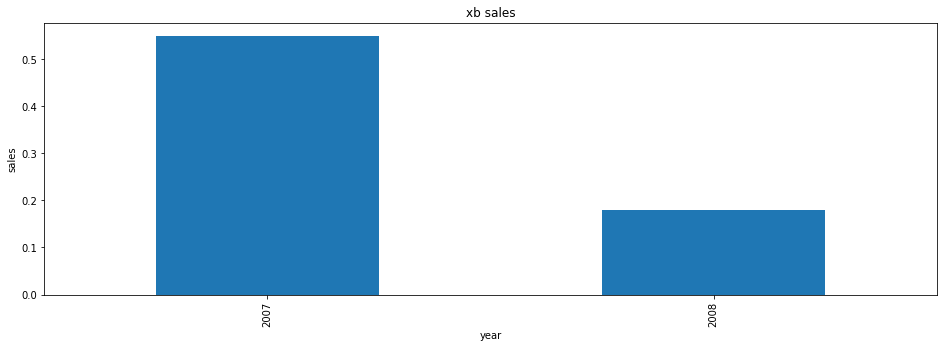

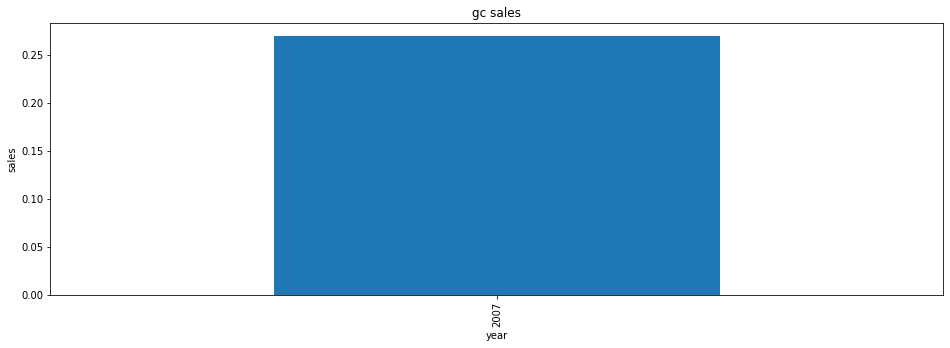

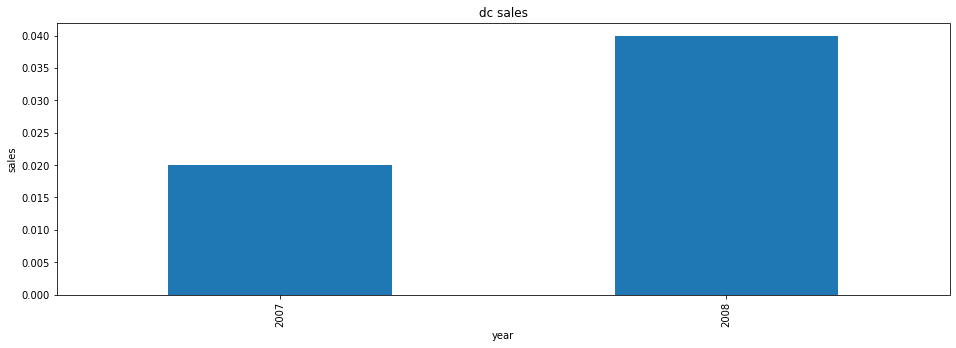

In [25]:
for platform in relev_platform_rank.index:#loops through the platforms in relev_platform_rank
    p_slice=relev_data.query('platform == @platform')
    #creates a slice of rows from relev_data where the platform takes the present platform value
    p_slice.groupby('year_of_release')['total_sales'].sum().plot.bar(figsize=(16, 5))
    #groups the slice by year of release and fetches the sum of total sales for each year and plots a 
    #bar chart 
    plt.title('{} sales'.format(platform))#titles the chart with format '<platform> sales'
    plt.xlabel('year')#labels the x-axis as 'year'
    plt.ylabel('sales')#labels the y-axis as 'sales'
    plt.show()#shows the above chart
    print('')#prints an empty line

The shrinking platforms are ps3, x360, wiiu, pc, 3ds, and psv. Growing platforms are the ps4 and xone. Their bins are not be as big in 2016 probably due to the fact that the year 2016 had not yet ended when the data was gotten. But they are still in the early parts of their lifespan so we can expect them to make more profit at least for the next 2 or 3 years. The other platforms were already dead before 2016.

### Comparing sales on the potentially profitable platforms

Our potentially profitable platforms are those that can still make sales in 2017, judging from how good they did in 2016 i.e the xone, ps4, pc, 3ds, wiiu, and psv. So we will create a slice from our relev_data table containing rows where the platform is ps4 or xone. Then we will make a boxplot of sales by platform

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


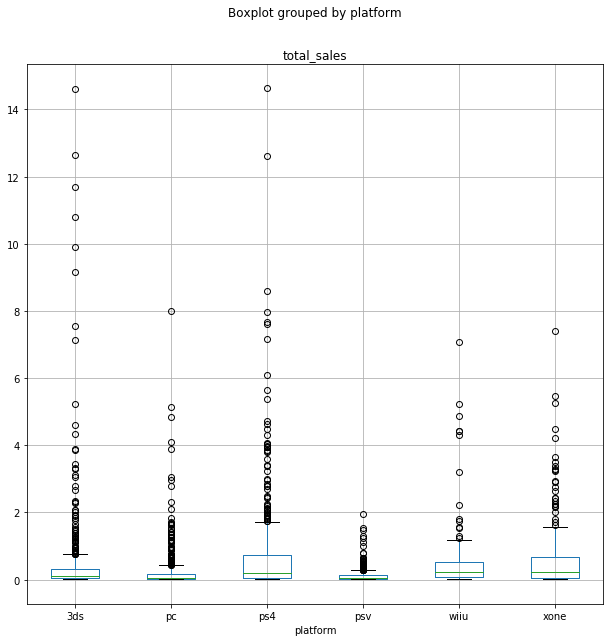

In [26]:
pprof_platforms=relev_data.query('platform == "ps4" | platform == "xone" | platform == "3ds" | platform == "wiiu" | platform == "pc" | platform == "psv"')
#creates a slice from relev_data with rows where the platform is either of the potentially profitable
#platforms we mentioned
pprof_platforms.boxplot(column='total_sales', by='platform', figsize=(10, 10))
#creates a boxplot from the slice of sales by platform
plt.show()#shows the plot above 

There is no drastic difference between the medians and the typical sales intervals for ps4, wiiu, and xone, while the other medians are low with psv's being the closest to zero. However, the ps4 has a lot more outliers than the xone, with the highest outlier bagging around 14.5 million dollars. 

### The effect of user and proffessional reviews on sales

First we will build scatter plots comparing critic score and user score against the total_sales. We will use the ps4 platform

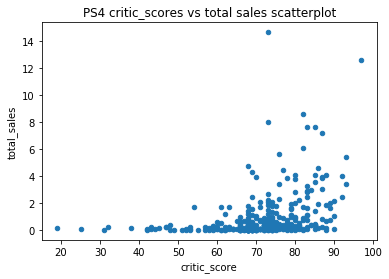

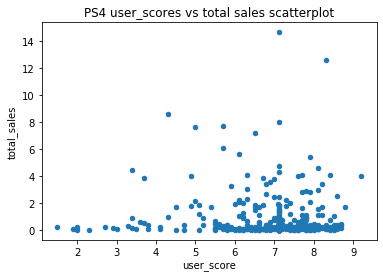

In [27]:
ps4_data = pprof_platforms.query('platform == "ps4"')
#creates a slice of rows from pprof_platforms where the platform is ps4
cols=['critic_score', 'user_score']#creates an array with entries: 'critic_score' and 'user_score'
for column in cols:#loops through the entries in the array
    ps4_data.plot(x=column, y='total_sales', kind='scatter')
    plt.title('PS4 {}s vs total sales scatterplot'.format(column))
    #plots a scatterplot for the score against total sales
    plt.show()#shows the scatterplot

Now let us look for the correlation coefficients. This coefficient ranges between 0 and 1 (for positive correlation) and between -1 and 0 (negative correlation). If the correlation is more than 0.5, it implies a strong positive correlation; lower than -0.5 implies strong negative correlation. Between -0.5 and 0.5 implies little to no correlation or a correlation that can't be expressed linearly

In [28]:
print(ps4_data['critic_score'].corr(ps4_data['total_sales']))
#prints the correlation coefficient critic score vs total sales 
print(ps4_data['user_score'].corr(ps4_data['total_sales']))
#prints the correlation coefficient user score vs total sales

0.35140802447758474
-0.045390861003324096


The results show that both user_score and critic_score have little to no linear correlation with sales. This means that high quality doesn't guarantee commercial success for ps4 games. Let us check this ou for a few other platforms. First, Xbox One. Scatterplot...

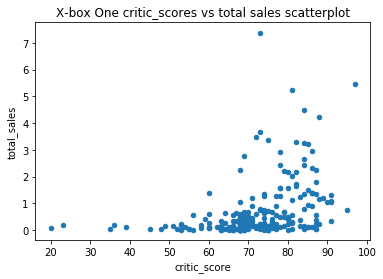

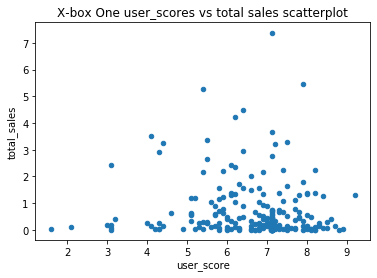

In [29]:
xone_data = pprof_platforms.query('platform == "xone"')
cols=['critic_score', 'user_score']
for column in cols:
    xone_data.plot(x=column, y='total_sales', kind='scatter')
    plt.title('X-box One {}s vs total sales scatterplot'.format(column))
    plt.show()

Correlation coefficients...

In [30]:
print(xone_data['critic_score'].corr(xone_data['total_sales']))
print(xone_data['user_score'].corr(xone_data['total_sales']))

0.3786581617346427
-0.0895737046060437


We arrive at the same conclusion here: Critic scores and user scores have little to no linear correlation with total sales. Next up, PS3. Scatterplot...

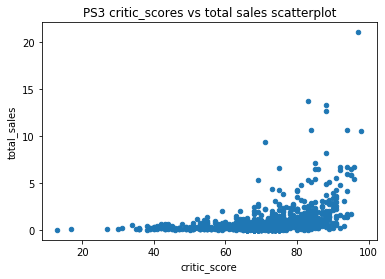

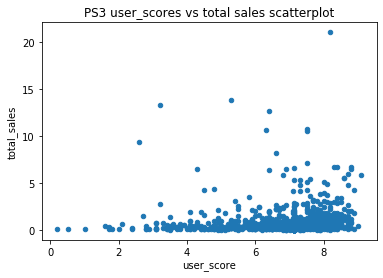

In [31]:
ps3_data=relev_data.query('platform == "ps3"')
cols=['critic_score', 'user_score']
for column in cols:
    ps3_data.plot(x=column, y='total_sales', kind='scatter')
    plt.title('PS3 {}s vs total sales scatterplot'.format(column))
    plt.show()

Correlation cofficients...

In [32]:
print(ps3_data['critic_score'].corr(ps3_data['total_sales']))
print(ps3_data['user_score'].corr(ps3_data['total_sales']))

0.4043688215235061
0.07737406610563416


Still no correlation with total sales

### The most profitable genres

Let us first of all see how many of each genre were released since 2007

In [33]:
genre_count=relev_data['genre'].value_counts().sort_values(ascending=False)
#counts appearances of each unique value in the column and sorts in descending order
genre_count

action          2236
misc            1168
sports          1145
adventure        958
role-playing     896
shooter          683
simulation       564
racing           499
fighting         361
strategy         360
puzzle           328
platform         290
Name: genre, dtype: int64

We can plot a bar chart for that

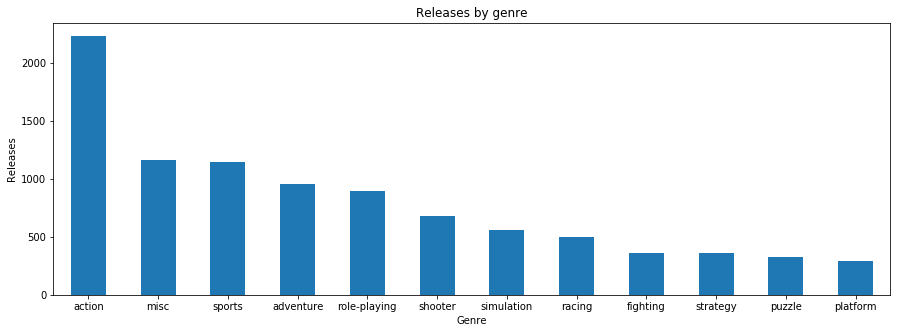

In [34]:
genre_count.plot.bar(rot=0, figsize=(15, 5))
plt.title('Releases by genre')
plt.xlabel('Genre')
plt.ylabel('Releases')
plt.show()

Action had the most releases by far (over 2000), the least being platform games (less than 500). Now let us rank them by total sales

In [35]:
genre_profit=relev_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
#groups relev_data by genre and sums the total sales for each genre sorting the values in descending order
genre_profit

genre
action          1069.56
shooter          684.68
sports           664.33
misc             496.45
role-playing     466.12
racing           267.26
platform         231.01
simulation       200.75
fighting         166.26
adventure        130.35
puzzle            79.89
strategy          70.54
Name: total_sales, dtype: float64

Bar chart...

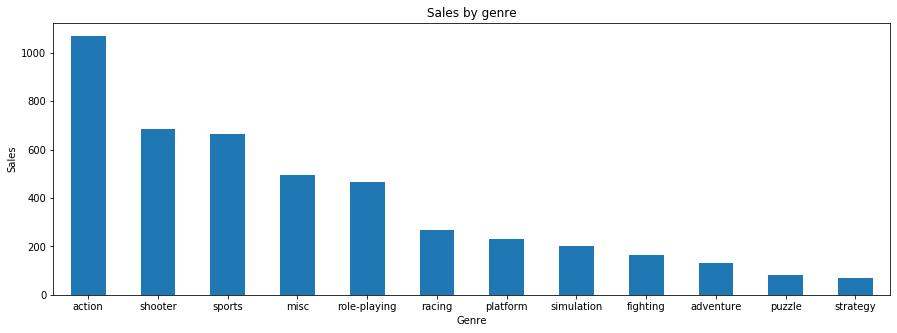

In [36]:
genre_profit.plot.bar(rot=0, figsize=(15, 5))
plt.title('Sales by genre')
plt.xlabel('Genre')
plt.ylabel('Sales')
plt.show()

The most profitable genres are action (by far, over 1B dollars), shooter, and sports games. The bottom involves adventure, puzzle and strategy. The genres that sell most (action to role-playing) mostly require very high graphics while the ones that sell least (racing and the rest) mostly do not require as much graphical work on the part of the designers. 

## Users profile for each region

### North American User Profile

We will find the platforms (top 5), genres (top 5), and game ratings that sell most in North America.

platform
x360    560.41
wii     426.04
ps3     384.65
ds      276.07
ps4     108.74
Name: na_sales, dtype: float64


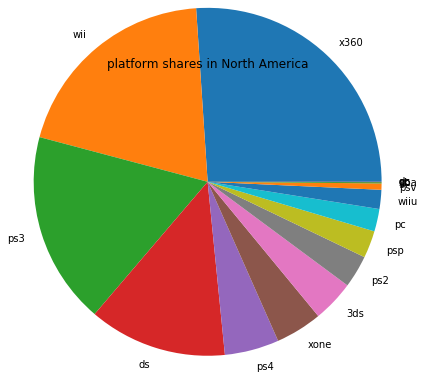


genre
action          501.81
shooter         353.06
sports          327.98
misc            264.51
role-playing    175.79
Name: na_sales, dtype: float64


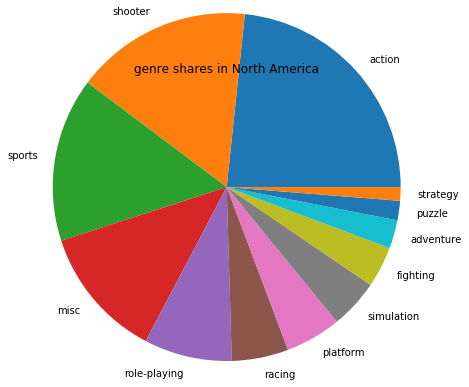


rating
E       780.19
M       578.09
T       495.89
E10+    295.30
EC        1.32
Name: na_sales, dtype: float64


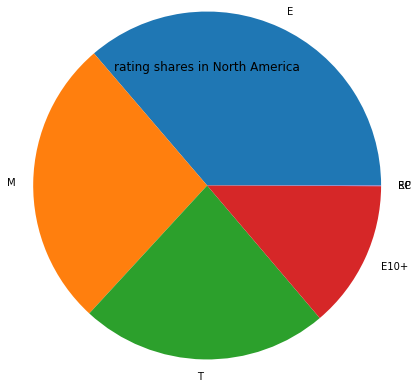

In [44]:
cols=['platform', 'genre', 'rating']
#creates an array called cols with entries 'platform', 'genre', and 'rating'
for col in cols:#loops through the cols array
    na_slice=relev_data.groupby(col)['na_sales'].sum().sort_values(ascending=False)
    #groups relev_data by the present column and gets the sum of the north american sales for each of its 
    #values sorting them in descending order
    print(na_slice.head())#prints the first 5 rows of the grouping
    plt.pie(na_slice, labels=na_slice.index, radius=2)#creates a pie chart for our grouping
    plt.title('{} shares in North America'.format(col))
    #titles the pie chart in the format '<col> shares in North America'
    plt.show()#shows the chart above
    print('')#prints an empty line

For the North American market, the top 5 platforms are x360 (which is made in the US), wii, ps3, ds, and ps4. 4 out of those are home consoles, and the ds is portable. The top 5 genres are action, shooter, sports, miscellaneous, and role-playing. Games rated 'E' (Everyone) sell the highest, followed by 'M' (Mature), followed by 'T' (Teen) to make the top 3. 

### The EU User Profile

We will do the same for the EU sales.

platform
ps3     322.91
x360    259.49
wii     218.59
ps4     141.09
ds      120.40
Name: eu_sales, dtype: float64


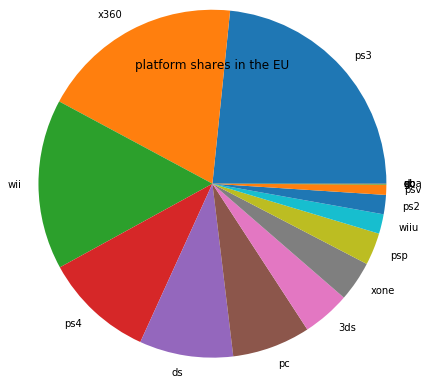


genre
action     341.95
shooter    232.36
sports     212.63
misc       129.02
racing     105.72
Name: eu_sales, dtype: float64


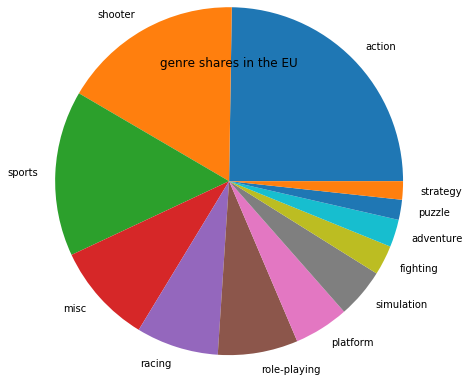


rating
E       506.68
M       410.73
T       296.03
E10+    167.87
RP        0.08
Name: eu_sales, dtype: float64


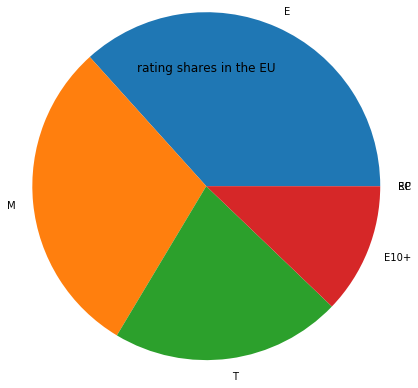

In [45]:
cols=['platform', 'genre', 'rating']
#creates an array called cols with entries 'platform', 'genre', and 'rating'
for col in cols:#loops through the cols array
    eu_slice=relev_data.groupby(col)['eu_sales'].sum().sort_values(ascending=False)
    #groups relev_data by the present column and gets the sum of the eu_sales for each of its 
    #values sorting them in descending order
    print(eu_slice.head())#prints the first 5 rows of the grouping
    plt.pie(eu_slice, labels=eu_slice.index, radius=2)#creates a pie chart for our grouping
    plt.title('{} shares in the EU'.format(col))
    #titles the pie chart in the format '<col> shares in the EU'
    plt.show()#shows the chart above
    print('')#prints an empty line

For the EU market, the top 5 platforms are PS3, X360, wii, PS4, and DS. We still see a domination of home consoles. The top 5 genres are Action, Shooter, Sports, Miscellaneous, and Racing. Games rated E still sell highest, followed by M, and T.

### Japanese User Profile

We will do the same for jp_sales

platform
ds     103.48
3ds    100.67
ps3     79.11
psp     67.14
wii     60.18
Name: jp_sales, dtype: float64


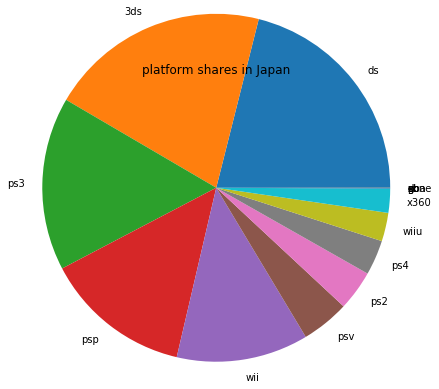


genre
role-playing    151.01
action           97.22
misc             49.88
sports           40.67
adventure        26.93
Name: jp_sales, dtype: float64


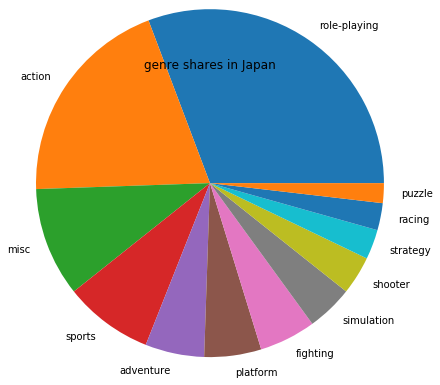


rating
T       230.30
E       185.06
M        43.83
E10+     31.91
RP        0.00
Name: jp_sales, dtype: float64


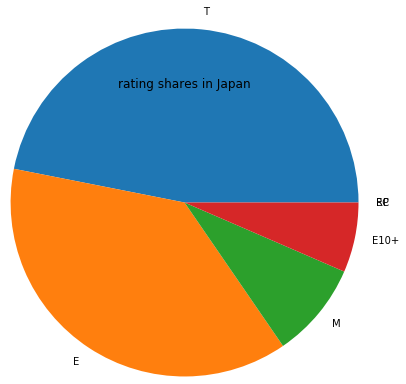

In [47]:
cols=['platform', 'genre', 'rating']
#creates an array called cols with entries 'platform', 'genre', and 'rating'
for col in cols:#loops through the cols array
    jp_slice=relev_data.groupby(col)['jp_sales'].sum().sort_values(ascending=False)
    #groups relev_data by the present column and gets the sum of the jp_sales for each of its 
    #values sorting them in descending order
    print(jp_slice.head())#prints the first 5 rows of the grouping
    plt.pie(jp_slice, labels=jp_slice.index, radius=2)#creates a pie chart for our grouping
    plt.title('{} shares in Japan'.format(col))
    #titles the pie chart in the format '<col> shares in Japan'
    plt.show()#shows the chart above
    print('')#prints an empty line

For the Japanese market, the top 5 platforms are ds, 3ds, ps3, psp, and wii. We see a preference for handheld platforms here (ds, 3ds, and psp; all of which are made in Japan). The top genres are role-playing, followed by action, miscellaneous, sports, and adventure. The top-selling ratings are T, followed by E, and M.  

- **Conclusion**

We have studied user preferences throughout the North American, EU, and Japanese regions. The North American and EU regions show a preference for home consoles (e.g x360, ps3, wii, and ps4) while the Japanese market shows a general preference for handhelds (e.g ds, 3ds, and psp). North American and EU markets show a preference for Action, Shooter, and Sports games while the Japanese market tends to like Role-playing most, but also Action, and Sports games after. As for ratings, the top 3 are the same in all regions; North America and the EU prefer games rated E, followed by M, and T, while in Japan, the preference is T, followed by E, and then M.

## Hypothesis Testing <a name='step5'></a>

### Hypothesis 1: 'Average user ratings of the Xbox One and PC platforms are the same'

Our Null Hypothesis will be: 'Average user ratings of the Xbox One and PC platforms are the same'. Our Alternate Hypothesis will be: 'Average user ratings of the Xbox One and PC platforms are different'. Let us create the necessary slices: A slice for 'platform == "xone"', and another for 'platform == "pc"'

In [48]:
xone_slice = relev_data.query('platform == "xone"')
#creates a slice of rows from relev_data where the platform is xone for xbox one
xone_slice.info()#general info about our slice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 99 to 16672
Data columns (total 12 columns):
name               247 non-null object
platform           247 non-null object
year_of_release    247 non-null int64
genre              247 non-null object
na_sales           247 non-null float64
eu_sales           247 non-null float64
jp_sales           247 non-null float64
other_sales        247 non-null float64
critic_score       247 non-null float64
user_score         247 non-null float64
rating             247 non-null object
total_sales        247 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 25.1+ KB


In [49]:
pc_slice = relev_data.query('platform == "pc"')
#creates a slice of rows from relev_data where the platform is pc
pc_slice.info()#general info about our slice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741 entries, 85 to 16705
Data columns (total 12 columns):
name               741 non-null object
platform           741 non-null object
year_of_release    741 non-null int64
genre              741 non-null object
na_sales           741 non-null float64
eu_sales           741 non-null float64
jp_sales           741 non-null float64
other_sales        741 non-null float64
critic_score       741 non-null float64
user_score         741 non-null float64
rating             741 non-null object
total_sales        741 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 75.3+ KB


Before testing the hypothesis, we need to test whether the variances can be considered to be homogeneous. To do so, we will implement Levene's test using the method st.levene() which will take our user_score columns from both slices as arguments, and also set the parameter "center='mean'". This method returns a p-value that we will compare to a threshold called the statistical significance (commonly called alpha). We will set alpha to 5%. If the p-value returned is greater than our alpha, then the variances can be considered homogeneous. If it is lower than our alpha, then the variances can't be considered homogeneous

In [50]:
alpha = 0.05 #sets our alpha to 5%
result = st.levene(xone_slice['user_score'], pc_slice['user_score'], center='mean')
#implements Levene's test on our slice columns specifying that the variances were calculated from the mean
print('p-value:', result.pvalue)#prints the p-value
if result.pvalue > alpha:#if the p-value is greater than alpha
    print('The variances are approximately the same')#The variances are approx. the same
else:#i.e if the p-value is less than alpha
    print('The variances are too far apart to be considered homogeneous')
    #The variances can't be considered homogeneous

p-value: 0.06940698292762643
The variances are approximately the same


The p-value is greater than our alpha so we can consider the variances to be the same for our hypothesis test. To test our hypothesis, we will use the st.ttest_ind() method which tests for likelihood of the averages (means) of 2 statistical populations (in this case, both of our slice columns) being equal. It takes both slice columns as arguments, and we will set the parameter 'equal_var=True' since we concluded from Levene's test that the variances can be considered homogeneous. It also returns a p-value that we will compare to our alpha. If the p-value is greater than our alpha, it means that the averages are likely to be the same in which case, we can't reject our null hypothesis. Otherwise, we can reject the null hypothesis.

In [51]:
alpha = 0.05 #sets alpha to 5%
result = st.ttest_ind(xone_slice['user_score'], pc_slice['user_score'], equal_var=True)
#implements the t-test on our slice columns specifying that we have, at least, approximately equal variances
print('p-value:', result.pvalue)#prints the p-value
if result.pvalue > alpha:#if the p-value is greater than alpha
    print('We cannot reject the null hypothesis')
    #the means are likely to be equal, so we can't reject the null hypothesis
else:#i.e if the p-value is less than alpha 
    print('We reject the null hypothesis')
    #the means aren't likely to be equal, so we reject the null hypothesis

p-value: 0.0955224438332763
We cannot reject the null hypothesis


The p-value is more than our alpha, which means the averages (means) of our 2 statistical populations are likely to be equal. Therefore, we cannot reject our null hypothesis.

### Hypothesis 2: 'Average user ratings for the Action and Sports genres are different'

Our Null Hypotghesis will be: 'Average user ratings for the Action and Sports genres are the same', so our Alternate Hypothesis will be: 'Average user ratings for the Action and Sports genres are different'. Let's create the necessary slices from our relev_data table; one where 'genre =="action"', and the other where 'genre =="sports"'

In [52]:
action_slice = relev_data.query('genre == "action"')
action_slice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 16 to 16710
Data columns (total 12 columns):
name               2236 non-null object
platform           2236 non-null object
year_of_release    2236 non-null int64
genre              2236 non-null object
na_sales           2236 non-null float64
eu_sales           2236 non-null float64
jp_sales           2236 non-null float64
other_sales        2236 non-null float64
critic_score       2236 non-null float64
user_score         2236 non-null float64
rating             2236 non-null object
total_sales        2236 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 227.1+ KB


In [53]:
sports_slice = relev_data.query('genre == "sports"')
sports_slice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 3 to 16700
Data columns (total 12 columns):
name               1145 non-null object
platform           1145 non-null object
year_of_release    1145 non-null int64
genre              1145 non-null object
na_sales           1145 non-null float64
eu_sales           1145 non-null float64
jp_sales           1145 non-null float64
other_sales        1145 non-null float64
critic_score       1145 non-null float64
user_score         1145 non-null float64
rating             1145 non-null object
total_sales        1145 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 116.3+ KB


Same as before we will administer Levene's test to check whether the variances are homogeneous

In [54]:
alpha = 0.05 #sets our alpha to 5%
result = st.levene(action_slice['user_score'], sports_slice['user_score'], center='mean')
#implements Levene's test on our slice columns specifying that the variances were calculated from the mean
print('p-value:', result.pvalue)#prints the p-value
if result.pvalue > alpha:#if the p-value is greater than alpha
    print('The variances are approximately the same')#The variances are approx. the same
else:#i.e if the p-value is less than alpha
    print('The variances are too far apart to be considered homogeneous')
    #The variances can't be considered homogeneous

p-value: 5.932204906456892e-14
The variances are too far apart to be considered homogeneous


In this case, the variances can't be considered homogeneous since the p-value returned is lower than our alpha. So when applying our st.ttest_ind() method to test for the equality of the averages, we will set the parameter 'equal_var=False'. Again, we will compare the p-value returned to our alpha. If the p-value is greater than our alpha, it means that the averages are likely to be the same in which case, we will reject our null hypothesis. Otherwise, we can't reject the null hypothesis.

In [55]:
alpha = 0.05 #sets our alpha to 5%
result = st.ttest_ind(action_slice['user_score'], sports_slice['user_score'], equal_var=False)
#implements the t-test on our slice columns specifying that our variances are different
print('p-value:', result.pvalue)#prints the p-value
if result.pvalue > alpha:#if the p-value is greater than alpha
    print('We cannot reject the null hypothesis')
    #the means are likely to be equal, so we can't reject the null hypothesis
else:#i.e if the p-value is less than alpha
    print('We reject the null hypothesis')
    #the means are not likely to be equal, so we can reject the null hypothesis

p-value: 1.2067195054177038e-09
We reject the null hypothesis


The p-value returned is less than our alpha, meaning the difference between the averages (means) of our 2 statistical populations is statiscally significant. This rejects our null hypothesis, upholding the hypothesis that the averages are different (alternate hypothesis)

## Overall Conclusion <a name='step6'></a>

We filled in missing values. We determined the most profitable genres, ratings, and platforms. We also saw that critic and user scores had little to no linear correlation with total sales We created user profiles for the North American, EU, and Japanese markets. We tested hypotheses; we could not reject the hypothesis that Average user ratings of the Xbox One and PC platforms are the same, and the hypothesis that Average user ratings for the Action and Sports genres are different was upheld.